<h1 style="text-align: center;">Credit Card Fraud Detection using Various Machine Learning Techniques</h1>

---

### Introduction
In this analysis, I utilize undersampling techniques to address the imbalanced dataset. Moreover, I construct various predictive models to assess their efficacy in distinguishing between regular payment transactions and fraudulent ones. Let's delve in and commence our investigation!

### Objective
<ul>
<li>Cleaning and preprocessing the dataset.
<li>Exploring techniques to handle an imbalanced dataset.
<li>Identifying the optimal classification model.
<li>Applying the Expected Value framework.
</ul>

### Outline
1. [Data Review](#datareview)

2. [Exploratory Analysis](#exploratory)

3. [Data Preprocessing](#datapreprocessing)
---

<div id='datareview'/>

## 1. Data review

### About the dataset ([Data Source](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud))

The dataset contains transaction records spanning two days, comprising 492 instances of fraud out of a total of 284,807 transactions. This dataset demonstrates a considerable class imbalance, as the positive class (frauds) accounts for just approximately 0.172% of all transactions.

**Target variable:**
- *'Class':* This is a binary variable where 0 represents "Not fraud" and 1 represents "Fraud". 

**Feature variables:** 
- *'Time':* The seconds elapsed between each transaction and the first transaction in the dataset.
- *'Amount':* The transaction amount.
- *'V1', 'V2', ..., 'V28':* The principal components have been derived from the PCA transformation. Unfortunately, due to confidentiality reasons, the original features and any supplementary background information about the data cannot be disclosed.

**Now, it's time to analyze the dataset thoroughly to gain valuable insights, comprehend the data, and identify any potential issues or trends that may exist.**

In [2]:
## Importing all the necessary libraries for data loading, cleaning, exploring, machine learning, etc.
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
from keras.layers import InputLayer, Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

In [3]:
## Loading the dataset with pyarrow as the back engine to reduce load times
pd.options.mode.copy_on_write = True
data = pd.read_csv(r'creditcard.csv', engine='pyarrow')


<div id='exploratory'/>

## Exploratory Analysis

In [4]:
## Exploring the features of our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.shape

(284807, 31)

In [ ]:
#%timeit pd.read_csv('creditcard.csv')


In [ ]:
#%timeit pd.read_csv('creditcard.csv', dtype_backend='pyarrow' engine='pyarrow')

In [ ]:
data.describe()

In [ ]:
new_data = data.copy()

In [ ]:
## Getting the column names
columns = new_data.columns

## Iteratating through the columns with index 'i' and column name 'col'
for i, col in enumerate(columns):
    ## Plotting the distplot only for the first and last two columns
    if i == 0 or i >= len(columns) - 2:
        plt.figure(i)
        sns.distplot(new_data[col])
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()


In [ ]:
## Creating a correlation heatmap to find out which features are important for our purpose
corr_matrix = data.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corr_matrix,cmap='YlGnBu', linecolor="black" ,annot=True, square=True)
plt.tight_layout()  ## Adjusting the layout to prevent label cutoffs
plt.show()

By analyzing the correlation matrix, we can obtain valuable information about the connections between the feature variables and the target variables in the dataset. The correlation plot offers a comprehensive visualization of the pairwise correlations, enabling us to detect patterns and dependencies among the variables. Notably, the following feature variables display significant correlations with the target variable:

Positive correlation: 'V2', 'V4', and 'V11'.</br>
Negative correlation: 'V3', 'V7', 'V10', 'V12', 'V14', 'V16', and 'V17'.</br>
On the other hand, the remaining variables exhibit either weak correlations or no correlation at all with the target variable.

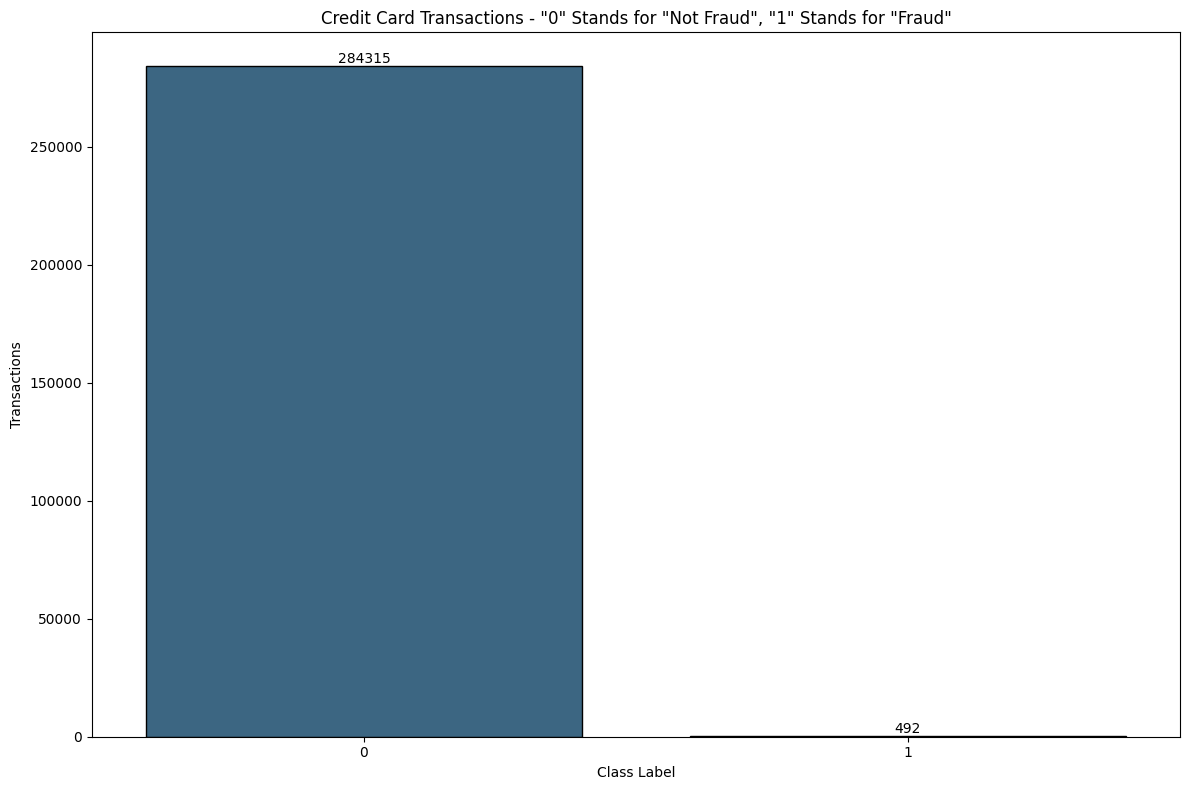

In [8]:

## Create the bar chart with additional details
plt.figure(figsize=(12, 8))  # Set the size of the figure (width=8 inches, height=6 inches)
ax = sns.countplot(x='Class', data=data, palette='viridis', edgecolor='black')

# Customize the plot with labels and title
plt.title('Credit Card Transactions - "0" Stands for "Not Fraud", "1" Stands for "Fraud"')
plt.xlabel('Class Label')
plt.ylabel('Transactions')

# Add annotations above the bars showing the exact counts
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()  # Adjust the layout to prevent label cutoffs

plt.show()


In [ ]:
new_data

In [9]:
## Making a copy of the data and applying robust data scaling on the Amount column
## Normalising the Time column
r_scaler = RobustScaler
new_data['Amount'] = r_scaler().fit_transform(new_data['Amount'].to_numpy().reshape(-1, 1))
time = new_data['Time']
new_data['Time'] = (time - time.min()) / (time.max() - time.min())

In [21]:
## Randomising how the data observations appear
new_data = new_data.sample(frac=1)
new_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
12849,0.130596,-0.730591,0.464210,2.206461,-2.013016,0.241234,0.402515,0.331219,-0.080937,2.700053,...,-0.184885,0.021091,-0.478446,-0.981558,0.509467,-0.762774,-0.198450,-0.170132,-0.141829,0
36715,0.223720,0.938707,-0.073768,1.262434,2.711881,-0.694834,0.406251,-0.391960,0.136842,0.061780,...,-0.038799,-0.186149,-0.100430,0.043335,0.318809,-0.034418,0.024230,0.052159,1.234263,0
195550,0.758797,1.522794,-2.131882,-0.339569,-0.734238,-1.652509,0.234064,-1.198732,0.185820,0.199164,...,0.482303,0.693220,0.036520,0.778046,-0.589319,-0.317277,-0.027026,0.013465,3.970377,0
236318,0.860931,-0.117193,1.088893,-0.654295,-0.755615,0.960106,-0.175211,0.512495,-0.652595,-0.023424,...,0.434212,-1.151942,0.165830,0.127705,-0.428287,0.127272,0.246746,0.074703,-0.244673,0
52282,0.262564,1.429116,-0.445955,0.373138,-0.774694,-0.863402,-0.748527,-0.533059,-0.180418,-0.775044,...,-0.122623,-0.466197,0.063391,-0.132139,0.306399,-0.450312,0.010871,0.019274,-0.097813,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35199,0.219975,1.191758,-0.226330,0.923560,0.555863,-0.619562,0.492735,-0.727587,0.259650,0.697648,...,-0.090483,-0.094085,-0.088297,-0.455590,0.340096,0.349889,0.012884,0.009519,-0.146720,0
76419,0.327324,1.272872,-0.470163,0.373218,0.223557,-0.334031,0.770407,-0.706654,0.133356,-0.752198,...,-0.454407,-0.851788,-0.048259,-1.373591,0.324072,-0.382754,0.084388,0.033632,0.397960,0
10779,0.106162,-0.480232,1.133591,1.392438,0.772522,0.512337,-0.459334,1.744949,-0.782441,0.804726,...,-0.117844,0.257781,-0.228626,0.331822,0.163459,-0.427539,-0.514905,-0.431945,0.807657,0
61406,0.288300,1.204255,0.295461,0.676943,1.505048,-0.286381,-0.166194,-0.187384,0.102180,-0.687615,...,-0.313416,-1.060109,0.189381,-0.037659,-0.042811,0.609425,-0.080535,0.001811,-0.297352,0


<div id='Data Preprocessing'/>

## Data Preprocessing

In [22]:
## Splitting the data into train, validate, and test sets to be used in our ANN with numpy split (75%, 12%, 13%)
train_set, validation_set, test_set = np.split(new_data.sample(frac=1), [int(.75*len(new_data)), int(.87*len(new_data))])

In [23]:
## Ensuring the data split was successful by counting the observations on each set
train_set['Class'].value_counts(), validation_set['Class'].value_counts() , test_set['Class'].value_counts()

(Class
 0    213246
 1       359
 Name: count, dtype: int64,
 Class
 0    34118
 1       59
 Name: count, dtype: int64,
 Class
 0    36951
 1       74
 Name: count, dtype: int64)

In [24]:
## Transforming the sets into numpy arrays to be fed into the machine learning modesl/ANNs
train_set_np, validation_set_np, test_set_np = train_set.to_numpy(), validation_set.to_numpy(), test_set.to_numpy()
train_set_np.shape, validation_set_np.shape, test_set_np.shape

((213605, 31), (34177, 31), (37025, 31))

In [25]:
## Removing the target variable from 
x_train, y_train = train_set_np[:, :-1], train_set_np[:, -1]
x_val, y_val = validation_set_np[:, :-1], validation_set_np[:, -1]
x_test, y_test = test_set_np[:, :-1], test_set_np[:, -1]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((213605, 30), (213605,), (37025, 30), (37025,), (34177, 30), (34177,))

## Logistic Regression

In [26]:
## Implementing the logistic regression model, fitting the model and getting its performance
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
logistic_model.score(x_train, y_train)

0.9991432784813089

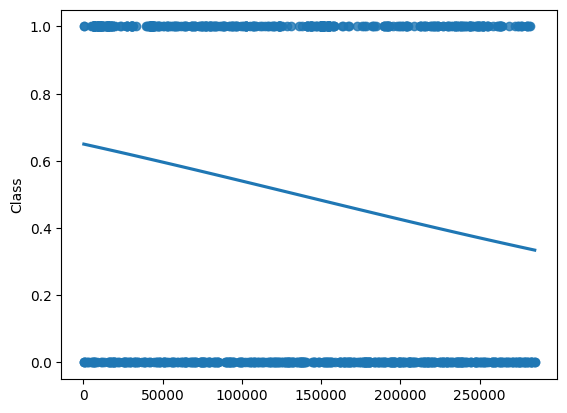

In [27]:
##
sns.regplot(x=X.index, y=Y, data=balanced_data, logistic=True, ci=None)
plt.show()


In [28]:
## Printing the classification report results
print(classification_report(y_val, logistic_model.predict(x_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     34118
       Fraud       0.91      0.69      0.79        59

    accuracy                           1.00     34177
   macro avg       0.96      0.85      0.89     34177
weighted avg       1.00      1.00      1.00     34177



In [36]:
## Deploying an Early Stopping technique to stop the ANN from training further once its maxed

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, ## minimium amount of change to count as an improvement
    patience=20, ## how many epochs to wait before stopping
    restore_best_weights=True)


In [37]:
## Deploying the ANN model
model = Sequential()
model.add(InputLayer((x_train.shape[1],)))
model.add(Dense(2, 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, 'sigmoid'))

checkpoint = ModelCheckpoint('model', save_best_only=True)
## Bringing the ANN model together
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
##Printing the ANN structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 62        
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 73
Trainable params: 69
Non-trainable params: 4
_________________________________________________________________


In [39]:
## Training the ANN model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=12, callbacks=[checkpoint, early_stopping])

Epoch 1/12
6673/6676 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9870

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


6676/6676 [==============================] - 18s 2ms/step - loss: 0.1089 - accuracy: 0.9870 - val_loss: 0.0052 - val_accuracy: 0.9994
Epoch 2/12
6676/6676 [==============================] - 15s 2ms/step - loss: 0.0092 - accuracy: 0.9988 - val_loss: 0.0067 - val_accuracy: 0.9995
Epoch 3/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.0097 - val_accuracy: 0.9994
Epoch 4/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0073 - val_accuracy: 0.9995
Epoch 5/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0078 - val_accuracy: 0.9995
Epoch 6/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0063 - val_accuracy: 0.9995
Epoch 7/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.0069 - val_accuracy: 0.9

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


6676/6676 [==============================] - 15s 2ms/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0051 - val_accuracy: 0.9995
Epoch 12/12
6676/6676 [==============================] - 14s 2ms/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0063 - val_accuracy: 0.9995


In [46]:
## Predicting values that are above 0.5, thus "frauds"
def neural_net_predictions(model, x):
  return (model.predict(x).flatten() > 0.5).astype(int)
neural_net_predictions(model, x_val)

1069/1069 [==============================] - 2s 1ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [41]:
print(classification_report(y_val, neural_net_predictions(model, x_val), target_names=['Not Fraud', 'Fraud']))

1069/1069 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     34118
       Fraud       0.86      0.83      0.84        59

    accuracy                           1.00     34177
   macro avg       0.93      0.92      0.92     34177
weighted avg       1.00      1.00      1.00     34177



In [42]:
## Train and Test accuracy model evaluation 
scores = model.evaluate(x_train,y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(x_test,y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

6676/6676 [==============================] - 11s 2ms/step - loss: 0.0069 - accuracy: 0.9994
Training Accuracy: 99.94%

1158/1158 [==============================] - 2s 2ms/step - loss: 0.0054 - accuracy: 0.9994
Testing Accuracy: 99.94%



In [44]:
## Making a prediction
y_pred = model.predict(x_test).flatten()
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

   1/1158 [..............................] - ETA: 56s

1158/1158 [==============================] - 2s 1ms/step
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [47]:
## Creating a confusion matrix object and 
cm = confusion_matrix(y_test, y_pred)
print(cm)
round(accuracy_score(y_test, y_pred)*100, 2)

[[36940    11]
 [   11    63]]


99.94

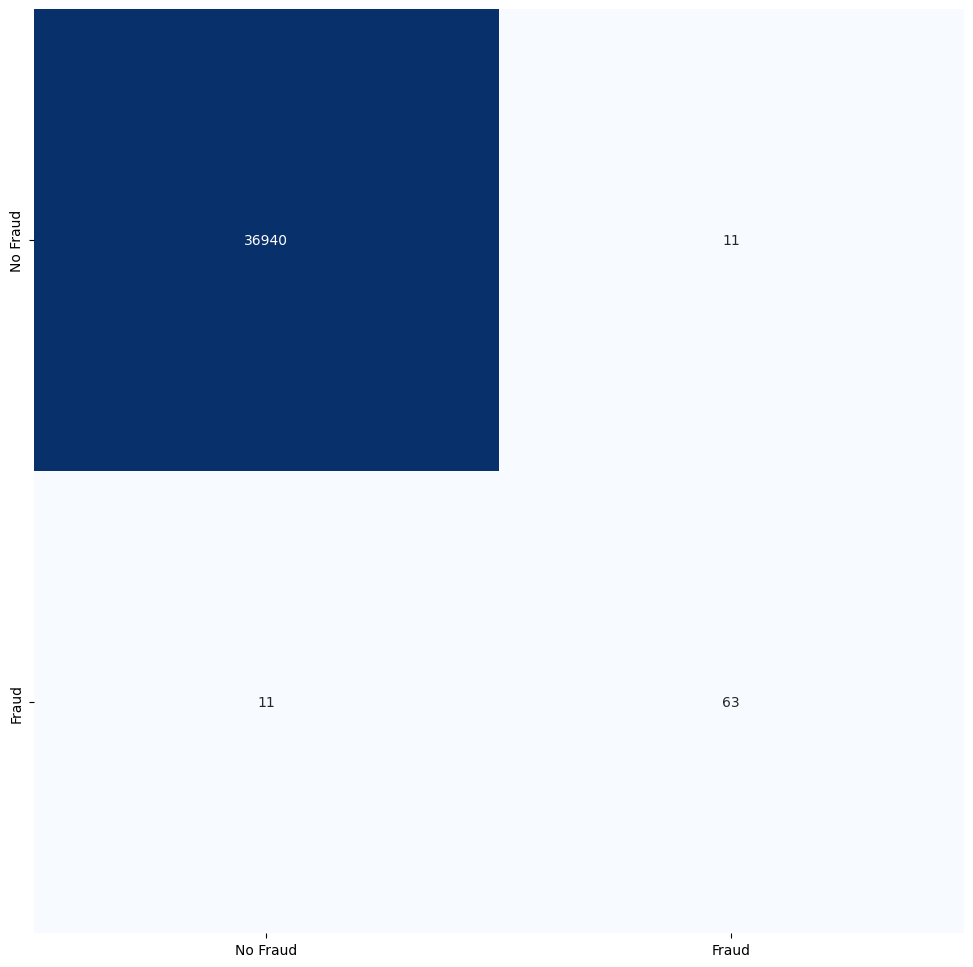

<Figure size 640x480 with 0 Axes>

In [48]:
## Plotting the confusion matrix with the help of a seaborn heatmap
plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, xticklabels=["No Fraud",'Fraud'], yticklabels=['No Fraud','Fraud'],
                cbar=False,cmap='Blues', fmt='g')
plt.figure().savefig( 'confusion_matrix_heatmap_imbalanced.png', dpi=200)
plt.show()



In [29]:
## Deploying a random forest object and making a prediction
rf = RandomForestClassifier(max_depth=7, n_jobs=-1)
rf.fit(x_train, y_train)
## Printing the classification report results of the random forest predictor
print(classification_report(y_val, rf.predict(x_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     34118
       Fraud       0.98      0.81      0.89        59

    accuracy                           1.00     34177
   macro avg       0.99      0.91      0.94     34177
weighted avg       1.00      1.00      1.00     34177



In [30]:
## Deploying a Gradient Boost object and making a prediction
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc.fit(x_train, y_train)
## Printing the classification report results of gradient boost predictor
print(classification_report(y_val, gbc.predict(x_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     34118
       Fraud       0.80      0.76      0.78        59

    accuracy                           1.00     34177
   macro avg       0.90      0.88      0.89     34177
weighted avg       1.00      1.00      1.00     34177



In [ ]:
train_set

## Undersampling to counter the effects of the imbalanced dataset

In [10]:
## 
not_frauds = new_data.query('Class == 0')
frauds = new_data.query('Class == 1')
not_frauds['Class'].value_counts(), frauds['Class'].value_counts()

(Class
 0    284315
 Name: count, dtype: int64,
 Class
 1    492
 Name: count, dtype: int64)

In [11]:
not_frauds['Class'].value_counts()

Class
0    284315
Name: count, dtype: int64

In [12]:
## Picking a random amount of "not fraud" observations based on the total amount of "fraud" ones, then concatenating them together into a dataframe
balanced_data = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_data['Class'].value_counts()

Class
1    492
0    492
Name: count, dtype: int64

In [ ]:
plt.figure(figsize=(12, 8))  ## Setting the size of the figure (width=8 inches, height=6 inches)
ax = sns.countplot(x='Class', data=balanced_data, palette='magma', edgecolor='black')

## Customizing the plot with labels and title
plt.title('Credit Card Transactions - "0" Stands for "Not Fraud", "0" Stands for "Not Fraud"')
plt.xlabel('Class Label')
plt.ylabel('Transactions')

## Adding annotations above the bars showing the exact counts
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

In [13]:
balanced_data.info()




<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 541 to 138224
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    984 non-null    float64
 1   V1      984 non-null    float64
 2   V2      984 non-null    float64
 3   V3      984 non-null    float64
 4   V4      984 non-null    float64
 5   V5      984 non-null    float64
 6   V6      984 non-null    float64
 7   V7      984 non-null    float64
 8   V8      984 non-null    float64
 9   V9      984 non-null    float64
 10  V10     984 non-null    float64
 11  V11     984 non-null    float64
 12  V12     984 non-null    float64
 13  V13     984 non-null    float64
 14  V14     984 non-null    float64
 15  V15     984 non-null    float64
 16  V16     984 non-null    float64
 17  V17     984 non-null    float64
 18  V18     984 non-null    float64
 19  V19     984 non-null    float64
 20  V20     984 non-null    float64
 21  V21     984 non-null    float64
 22  V2

In [14]:
balanced_data_np = balanced_data.to_numpy()

In [15]:
X = balanced_data.drop(columns='Class', axis=1)
Y = balanced_data['Class']

In [16]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(x_train_c, y_train_c, test_size=0.25, random_state=1) ## 0.25 x 0.8 = 0.2

In [17]:
x_train_c.shape, y_train_c.shape, x_test_c.shape, y_test_c.shape

((590, 30), (590,), (197, 30), (197,))

In [18]:
pd.Series(y_train_c).value_counts(), pd.Series(y_test_c).value_counts(), pd.Series(y_val_c).value_counts()

(Class
 0    298
 1    292
 Name: count, dtype: int64,
 Class
 0    99
 1    98
 Name: count, dtype: int64,
 Class
 1    102
 0     95
 Name: count, dtype: int64)

In [19]:
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_c, y_train_c)
print(classification_report(y_test_c, logistic_model_b.predict(x_test_c), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.91      0.98      0.94        99
       Fraud       0.98      0.90      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



In [33]:
early_stopping_b = callbacks.EarlyStopping(
    min_delta=0.001, ## Minimum amount of change to count as an improvement
    patience=20, ## How many epochs to wait before stopping
    restore_best_weights=True)

In [34]:
model_b = Sequential()
model_b.add(InputLayer((x_train.shape[1],)))
model_b.add(Dense(2, 'relu'))
model_b.add(BatchNormalization())
model_b.add(Dense(1, 'sigmoid'))

checkpoint = ModelCheckpoint('model_b', save_best_only=True)
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_b.fit(x_train_c, y_train_c,validation_data=(x_val_c, y_val_c), epochs=100, callbacks=[checkpoint,early_stopping_b])


Epoch 1/100
 1/19 [>.............................] - ETA: 31s - loss: 0.9657 - accuracy: 0.3750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 4s 117ms/step - loss: 0.7781 - accuracy: 0.5322 - val_loss: 0.7651 - val_accuracy: 0.6091
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 0.9677 - accuracy: 0.4062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.7080 - accuracy: 0.5949 - val_loss: 0.6860 - val_accuracy: 0.6548
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 0.7914 - accuracy: 0.5312

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 110ms/step - loss: 0.6639 - accuracy: 0.6237 - val_loss: 0.6517 - val_accuracy: 0.6599
Epoch 4/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6247 - accuracy: 0.6615

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 76ms/step - loss: 0.6289 - accuracy: 0.6593 - val_loss: 0.6327 - val_accuracy: 0.6802
Epoch 5/100
 1/19 [>.............................] - ETA: 0s - loss: 0.5525 - accuracy: 0.6250

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 73ms/step - loss: 0.6199 - accuracy: 0.6864 - val_loss: 0.6150 - val_accuracy: 0.7005
Epoch 6/100
 1/19 [>.............................] - ETA: 0s - loss: 0.7385 - accuracy: 0.6250

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 73ms/step - loss: 0.5887 - accuracy: 0.7017 - val_loss: 0.6036 - val_accuracy: 0.7107
Epoch 7/100
 1/19 [>.............................] - ETA: 0s - loss: 0.6659 - accuracy: 0.6250

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 68ms/step - loss: 0.5843 - accuracy: 0.7136 - val_loss: 0.5911 - val_accuracy: 0.7868
Epoch 8/100
 1/19 [>.............................] - ETA: 0s - loss: 0.5845 - accuracy: 0.7500

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 74ms/step - loss: 0.5681 - accuracy: 0.7525 - val_loss: 0.5807 - val_accuracy: 0.8071
Epoch 9/100
 1/19 [>.............................] - ETA: 0s - loss: 0.6680 - accuracy: 0.6562

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.5600 - accuracy: 0.7763 - val_loss: 0.5700 - val_accuracy: 0.8376
Epoch 10/100
 1/19 [>.............................] - ETA: 0s - loss: 0.5526 - accuracy: 0.7812

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.5494 - accuracy: 0.7780 - val_loss: 0.5601 - val_accuracy: 0.8528
Epoch 11/100
14/19 [=====================>........] - ETA: 0s - loss: 0.5360 - accuracy: 0.8237

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 68ms/step - loss: 0.5265 - accuracy: 0.8153 - val_loss: 0.5486 - val_accuracy: 0.8731
Epoch 12/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4279 - accuracy: 0.8438

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 88ms/step - loss: 0.5021 - accuracy: 0.8119 - val_loss: 0.5374 - val_accuracy: 0.8731
Epoch 13/100
13/19 [===================>..........] - ETA: 0s - loss: 0.5113 - accuracy: 0.8293

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.5042 - accuracy: 0.8373 - val_loss: 0.5269 - val_accuracy: 0.8832
Epoch 14/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4706 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.4861 - accuracy: 0.8593 - val_loss: 0.5157 - val_accuracy: 0.8832
Epoch 15/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4374 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.4682 - accuracy: 0.8610 - val_loss: 0.5063 - val_accuracy: 0.8934
Epoch 16/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4651 - accuracy: 0.8750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 77ms/step - loss: 0.4606 - accuracy: 0.8780 - val_loss: 0.4976 - val_accuracy: 0.8934
Epoch 17/100
19/19 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8729

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.4523 - accuracy: 0.8729 - val_loss: 0.4883 - val_accuracy: 0.9036
Epoch 18/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4076 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.4389 - accuracy: 0.8780 - val_loss: 0.4800 - val_accuracy: 0.9036
Epoch 19/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4599 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 80ms/step - loss: 0.4357 - accuracy: 0.8949 - val_loss: 0.4722 - val_accuracy: 0.9036
Epoch 20/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3821 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 97ms/step - loss: 0.4127 - accuracy: 0.9051 - val_loss: 0.4633 - val_accuracy: 0.9036
Epoch 21/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3336 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 76ms/step - loss: 0.4055 - accuracy: 0.8847 - val_loss: 0.4576 - val_accuracy: 0.9036
Epoch 22/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3709 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.3959 - accuracy: 0.8983 - val_loss: 0.4502 - val_accuracy: 0.9036
Epoch 23/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3567 - accuracy: 0.8438

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.3782 - accuracy: 0.9051 - val_loss: 0.4421 - val_accuracy: 0.9086
Epoch 24/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3408 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 74ms/step - loss: 0.3699 - accuracy: 0.9102 - val_loss: 0.4351 - val_accuracy: 0.9086
Epoch 25/100
 1/19 [>.............................] - ETA: 0s - loss: 0.5669 - accuracy: 0.8750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 73ms/step - loss: 0.3775 - accuracy: 0.9119 - val_loss: 0.4269 - val_accuracy: 0.9086
Epoch 26/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3516 - accuracy: 0.8750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.3572 - accuracy: 0.9068 - val_loss: 0.4197 - val_accuracy: 0.9086
Epoch 27/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3472 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 74ms/step - loss: 0.3502 - accuracy: 0.9102 - val_loss: 0.4121 - val_accuracy: 0.9086
Epoch 28/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2967 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 87ms/step - loss: 0.3434 - accuracy: 0.9169 - val_loss: 0.4028 - val_accuracy: 0.9137
Epoch 29/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3668 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.3371 - accuracy: 0.9203 - val_loss: 0.3946 - val_accuracy: 0.9137
Epoch 30/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3353 - accuracy: 0.8750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.3237 - accuracy: 0.9169 - val_loss: 0.3902 - val_accuracy: 0.9137
Epoch 31/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2881 - accuracy: 0.8438

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.3155 - accuracy: 0.9085 - val_loss: 0.3823 - val_accuracy: 0.9188
Epoch 32/100
 1/19 [>.............................] - ETA: 0s - loss: 0.4344 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 65ms/step - loss: 0.3011 - accuracy: 0.9373 - val_loss: 0.3779 - val_accuracy: 0.9188
Epoch 33/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2675 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.2884 - accuracy: 0.9186 - val_loss: 0.3716 - val_accuracy: 0.9188
Epoch 34/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2523 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 69ms/step - loss: 0.2970 - accuracy: 0.9203 - val_loss: 0.3611 - val_accuracy: 0.9239
Epoch 35/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2842 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.2810 - accuracy: 0.9305 - val_loss: 0.3521 - val_accuracy: 0.9239
Epoch 36/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2277 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 83ms/step - loss: 0.2706 - accuracy: 0.9407 - val_loss: 0.3474 - val_accuracy: 0.9239
Epoch 37/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1867 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 68ms/step - loss: 0.2704 - accuracy: 0.9356 - val_loss: 0.3463 - val_accuracy: 0.9239
Epoch 38/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2975 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.2648 - accuracy: 0.9339 - val_loss: 0.3450 - val_accuracy: 0.9239
Epoch 39/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1929 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 76ms/step - loss: 0.2545 - accuracy: 0.9339 - val_loss: 0.3355 - val_accuracy: 0.9239
Epoch 40/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1331 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 67ms/step - loss: 0.2336 - accuracy: 0.9492 - val_loss: 0.3299 - val_accuracy: 0.9188
Epoch 41/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2122 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.2370 - accuracy: 0.9390 - val_loss: 0.3261 - val_accuracy: 0.9239
Epoch 42/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1894 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.2346 - accuracy: 0.9407 - val_loss: 0.3216 - val_accuracy: 0.9239
Epoch 43/100
18/19 [===========================>..] - ETA: 0s - loss: 0.2375 - accuracy: 0.9358

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.2362 - accuracy: 0.9373 - val_loss: 0.3169 - val_accuracy: 0.9239
Epoch 44/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2721 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.2201 - accuracy: 0.9458 - val_loss: 0.3136 - val_accuracy: 0.9239
Epoch 45/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2810 - accuracy: 0.8750

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 93ms/step - loss: 0.2266 - accuracy: 0.9441 - val_loss: 0.3090 - val_accuracy: 0.9239
Epoch 46/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2773 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 80ms/step - loss: 0.2175 - accuracy: 0.9458 - val_loss: 0.3046 - val_accuracy: 0.9239
Epoch 47/100
 1/19 [>.............................] - ETA: 0s - loss: 0.3952 - accuracy: 0.8438

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 69ms/step - loss: 0.2199 - accuracy: 0.9356 - val_loss: 0.3046 - val_accuracy: 0.9239
Epoch 48/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2450 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.2123 - accuracy: 0.9424 - val_loss: 0.2982 - val_accuracy: 0.9239
Epoch 49/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1872 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.2035 - accuracy: 0.9475 - val_loss: 0.2937 - val_accuracy: 0.9239
Epoch 50/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1772 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 77ms/step - loss: 0.2005 - accuracy: 0.9458 - val_loss: 0.2921 - val_accuracy: 0.9188
Epoch 51/100
11/19 [================>.............] - ETA: 0s - loss: 0.2025 - accuracy: 0.9432

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.1977 - accuracy: 0.9441 - val_loss: 0.2905 - val_accuracy: 0.9239
Epoch 52/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2114 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.2006 - accuracy: 0.9458 - val_loss: 0.2877 - val_accuracy: 0.9188
Epoch 53/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1973 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 77ms/step - loss: 0.1968 - accuracy: 0.9441 - val_loss: 0.2845 - val_accuracy: 0.9188
Epoch 54/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2066 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.1880 - accuracy: 0.9525 - val_loss: 0.2798 - val_accuracy: 0.9188
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9424

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.1900 - accuracy: 0.9424 - val_loss: 0.2794 - val_accuracy: 0.9188
Epoch 56/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1954 - accuracy: 0.9427

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 72ms/step - loss: 0.1976 - accuracy: 0.9424 - val_loss: 0.2722 - val_accuracy: 0.9188
Epoch 57/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1839 - accuracy: 0.9424 - val_loss: 0.2757 - val_accuracy: 0.9137
Epoch 58/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1776 - accuracy: 0.9508 - val_loss: 0.2742 - val_accuracy: 0.9137
Epoch 59/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1744 - accuracy: 0.9475 - val_loss: 0.2738 - val_accuracy: 0.9239
Epoch 60/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1834 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.1691 - accuracy: 0.9576 - val_loss: 0.2694 - val_accuracy: 0.9137
Epoch 61/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2024 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 66ms/step - loss: 0.1691 - accuracy: 0.9508 - val_loss: 0.2684 - val_accuracy: 0.9137
Epoch 62/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1259 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 71ms/step - loss: 0.1724 - accuracy: 0.9441 - val_loss: 0.2645 - val_accuracy: 0.9137
Epoch 63/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1435 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.1708 - accuracy: 0.9441 - val_loss: 0.2618 - val_accuracy: 0.9137
Epoch 64/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1917 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 70ms/step - loss: 0.1808 - accuracy: 0.9492 - val_loss: 0.2564 - val_accuracy: 0.9188
Epoch 65/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1617 - accuracy: 0.9593 - val_loss: 0.2571 - val_accuracy: 0.9188
Epoch 66/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1557 - accuracy: 0.9610 - val_loss: 0.2588 - val_accuracy: 0.9188
Epoch 67/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1322 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 68ms/step - loss: 0.1632 - accuracy: 0.9542 - val_loss: 0.2556 - val_accuracy: 0.9239
Epoch 68/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1329 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 2s 93ms/step - loss: 0.1550 - accuracy: 0.9525 - val_loss: 0.2539 - val_accuracy: 0.9239
Epoch 69/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9525 - val_loss: 0.2545 - val_accuracy: 0.9289
Epoch 70/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1245 - accuracy: 0.9688

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 68ms/step - loss: 0.1497 - accuracy: 0.9576 - val_loss: 0.2517 - val_accuracy: 0.9239
Epoch 71/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1555 - accuracy: 0.9475 - val_loss: 0.2528 - val_accuracy: 0.9289
Epoch 72/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1412 - accuracy: 0.9627 - val_loss: 0.2521 - val_accuracy: 0.9239
Epoch 73/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1527 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 74ms/step - loss: 0.1512 - accuracy: 0.9542 - val_loss: 0.2507 - val_accuracy: 0.9239
Epoch 74/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1631 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 75ms/step - loss: 0.1488 - accuracy: 0.9525 - val_loss: 0.2504 - val_accuracy: 0.9289
Epoch 75/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9458 - val_loss: 0.2504 - val_accuracy: 0.9289
Epoch 76/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1974 - accuracy: 0.9062

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 69ms/step - loss: 0.1512 - accuracy: 0.9542 - val_loss: 0.2488 - val_accuracy: 0.9289
Epoch 77/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1400 - accuracy: 0.9576 - val_loss: 0.2500 - val_accuracy: 0.9289
Epoch 78/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1495 - accuracy: 0.9492 - val_loss: 0.2492 - val_accuracy: 0.9289
Epoch 79/100
13/19 [===================>..........] - ETA: 0s - loss: 0.1224 - accuracy: 0.9639

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 76ms/step - loss: 0.1312 - accuracy: 0.9610 - val_loss: 0.2482 - val_accuracy: 0.9289
Epoch 80/100
 1/19 [>.............................] - ETA: 0s - loss: 0.0839 - accuracy: 1.0000

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 74ms/step - loss: 0.1579 - accuracy: 0.9508 - val_loss: 0.2475 - val_accuracy: 0.9289
Epoch 81/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1400 - accuracy: 0.9610 - val_loss: 0.2481 - val_accuracy: 0.9289
Epoch 82/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1240 - accuracy: 0.9559 - val_loss: 0.2482 - val_accuracy: 0.9289
Epoch 83/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9375

INFO:tensorflow:Assets written to: model_b\assets


INFO:tensorflow:Assets written to: model_b\assets


19/19 [==============================] - 1s 67ms/step - loss: 0.1258 - accuracy: 0.9627 - val_loss: 0.2465 - val_accuracy: 0.9289
Epoch 84/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.9576 - val_loss: 0.2475 - val_accuracy: 0.9289
Epoch 85/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1314 - accuracy: 0.9559 - val_loss: 0.2486 - val_accuracy: 0.9289
Epoch 86/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1427 - accuracy: 0.9525 - val_loss: 0.2501 - val_accuracy: 0.9289
Epoch 87/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1227 - accuracy: 0.9576 - val_loss: 0.2509 - val_accuracy: 0.9289
Epoch 88/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1276 - accuracy: 0.9576 - val_loss: 0.2518 - val_accuracy: 0.9289
Epoch 89/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1378 - accuracy: 0.9525 - val_loss: 0.2520 - val_accuracy: 0.9289
Epoch 90/100
19/19

In [51]:
print(classification_report(y_val_c, neural_net_predictions(model_b, x_val_c), target_names=['Not Fraud', 'Fraud']))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

   Not Fraud       0.90      0.96      0.93        95
       Fraud       0.96      0.90      0.93       102

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



In [53]:
y_pred = model_b.predict(x_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

1158/1158 [==============================] - 2s 1ms/step
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [54]:
cm2 = confusion_matrix(y_test_c, y_pred_c)
print(cm2)
round(accuracy_score(y_test_c, y_pred)*100, 2)

[[48 51]
 [53 45]]


ValueError: Found input variables with inconsistent numbers of samples: [197, 37025]

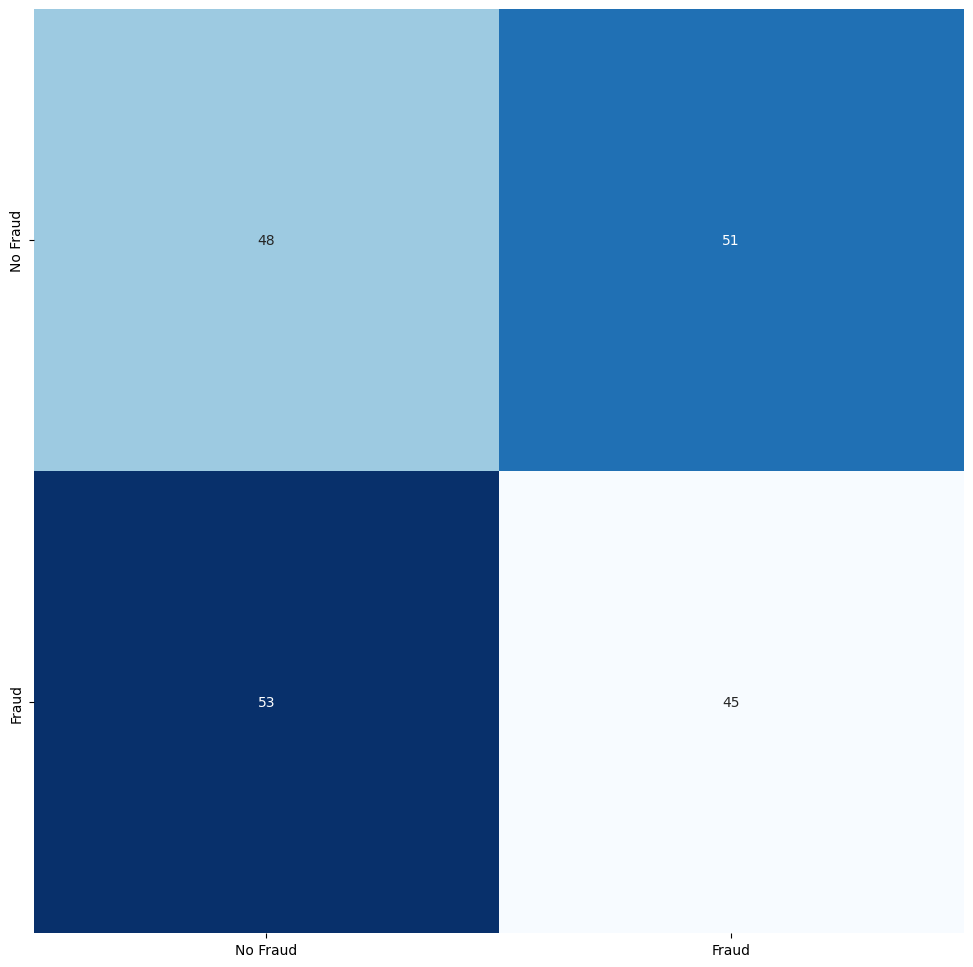

<Figure size 640x480 with 0 Axes>

In [55]:
## Plotting the confusion matrix of the ANN trained with balanced data
plt.subplots(figsize=(12, 12))
sns.heatmap(cm2, annot=True, xticklabels=["No Fraud",'Fraud'], yticklabels=['No Fraud','Fraud'],
                cbar=False,cmap='Blues', fmt='g')
plt.figure().savefig( 'confusion_matrix_heatmap_imbalanced.png', dpi=200)
plt.show()

In [31]:
## Random Forest approach with balanced data
rf_b = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_b.fit(x_train_c, y_train_c)
print(classification_report(y_val_c, rf.predict(x_val_c), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.81      1.00      0.89        95
       Fraud       1.00      0.77      0.87       102

    accuracy                           0.88       197
   macro avg       0.90      0.89      0.88       197
weighted avg       0.91      0.88      0.88       197



In [32]:
## Gradient Boost approach with balanced data
gbc_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_b.fit(x_train_c, y_train_c)
print(classification_report(y_val_c, gbc.predict(x_val_c), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.74      1.00      0.85        95
       Fraud       1.00      0.67      0.80       102

    accuracy                           0.83       197
   macro avg       0.87      0.83      0.82       197
weighted avg       0.87      0.83      0.82       197



In [56]:
# Create the data for the DataFrame
dataset = {
    'Model': ['Artificial Neural Network', 'Logistic Regression'],
    'Precion': [93, 94],
    'Recall': [93, 94],
    'f-1score': [93, 94]
}

# Create the DataFrame
dataset1 = pd.DataFrame(dataset)

# Display the DataFrame
print(dataset1)

                       Model  Precion  Recall  f-1score
0  Artificial Neural Network       93      93        93
1        Logistic Regression       94      94        94


<Figure size 2000x1500 with 0 Axes>

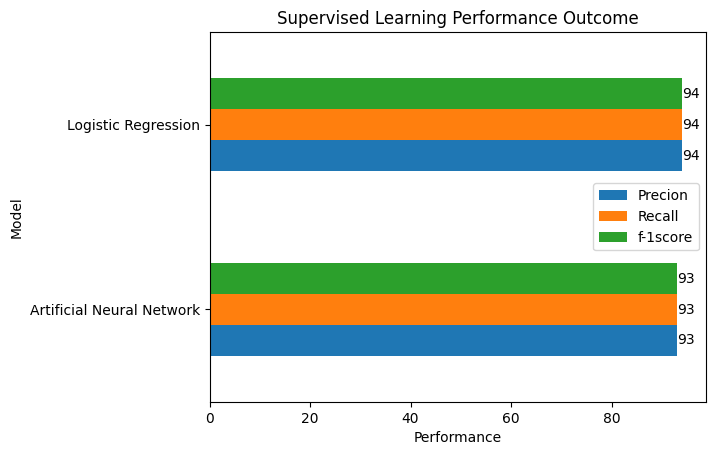

In [83]:
plt.figure(figsize=(20, 15))
# Create the horizontal bar chart
ax = dataset1.plot(kind='barh', x='Model', legend=True)
for container in ax.containers:
    ax.bar_label(container)

# Set labels and title
plt.xlabel('Performance')
plt.ylabel('Model')
plt.title('Supervised Learning Performance Outcome')

# Show the plot
plt.show()